# Lecture 21

by Lisa Yan

Adapted from Josh Hug, Joey Gonzalez, Ani Adhikari, Suraj Rampure

In [93]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


In [94]:
# formatting options

# big font helper
def adjust_fontsize(size=None):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    if size != None:
        SMALL_SIZE = MEDIUM_SIZE = BIGGER_SIZE = size
    plt.rcParams['font.size'] = SMALL_SIZE
    plt.rcParams['axes.titlesize'] = SMALL_SIZE
    plt.rcParams['axes.labelsize'] = MEDIUM_SIZE
    plt.rcParams['xtick.labelsize'] = SMALL_SIZE
    plt.rcParams['ytick.labelsize'] = SMALL_SIZE
    plt.rcParams['legend.fontsize'] = SMALL_SIZE
    plt.rcParams['figure.titlesize'] = BIGGER_SIZE
    # plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    # plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    # plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    # plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    # plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    # plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    # plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
def savefig(fname):
    if not SAVE_FIGURES_FLAG:
        # avoid memory overload
        return
    
    if not os.path.exists("images"):
        os.mkdir("images")
    fig = plt.gcf()
    fig.patch.set_alpha(0.0)
    plt.savefig(f"images/{fname}.png", bbox_inches = 'tight');
    
    
#plt.rcParams['figure.figsize'] = (4, 4)
#plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3

plt.style.use('fivethirtyeight')
sns.set_context("talk")
sns.set_theme()
#sns.set()
adjust_fontsize(20)


SAVE_FIGURES_FLAG = False

---

## (Notebook setup) Obtaining the Data

For this lecture, we will use the same Wisconsin Breast Cancer Dataset from [scikit learn](http://scikit-learn.org/stable/datasets/index.html#breast-cancer-wisconsin-diagnostic-database). This is the same dataset we used in Lecture 20, so we'll skip the EDA analysis.

Classification task: Given the `mean radius` of tumor cells in an image, predict if the tumor is malignant (1) or benign (0).

In [95]:
import sklearn.datasets

# load the data

data_dict = sklearn.datasets.load_breast_cancer()
data = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
# Target data_dict['target'] = 0 is malignant 1 is benign
data['malignant'] = (data_dict['target'] == 0).astype(int)

# split the data
from sklearn.model_selection import train_test_split
data_tr, data_te = train_test_split(data, test_size=0.10, random_state=42)
data_tr.reset_index(inplace=True, drop=True)
data_te.reset_index(inplace=True, drop=True)
print("Training Data Size: ", len(data_tr))
print("Test Data Size: ", len(data_te))

# X, Y are training data
X = data_tr[['mean radius']].to_numpy()
Y = data_tr['malignant'].to_numpy()

Training Data Size:  512
Test Data Size:  57


<Figure size 288x288 with 0 Axes>

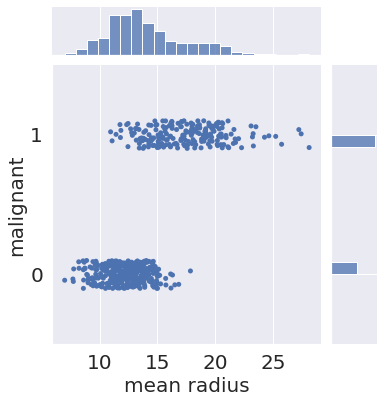

In [96]:
# manual to allow for jitter
plt.figure(figsize=(4,4))
g = sns.JointGrid(data = data, x = "mean radius", y = "malignant")
g.plot_marginals(sns.histplot)
g.plot_joint(sns.stripplot,
             orient='h', order=[1, 0],
             color=sns.color_palette()[0])
(g.ax_joint).set_xticks([10, 15, 20, 25])
savefig("jitter")
plt.show()

---

<br/><br/><br/>

# sklearn

The `linear_model.LogisticRegression` model ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) is what we want to use here. In order to recreate our specific model, there are a few parameters we need to set:
- `penalty = 'none'`: by default, `LogisticRegression` uses regularization. This is generally a good idea, which we'll discuss later.
- `fit_intercept = True`: we will fit an intercept term.
- `solver = 'lbgfs'`: need to specify a numerical optimization routine for the model (similar to gradient descent). `lbfgs` is one such type; it's the new default in `scikit-learn`.

<br/><br/>

### Fit

We'll fit a model with the mean radius feature and a bias intercept. So $\theta = (\theta_0, \theta_1)$ and our model is:

$$\hat{P}_{\theta} (Y = 1 | x) = \sigma(x^T\theta) = \sigma(\theta_0 + \theta_1 x_1)$$

In [97]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=True)
model.fit(X, Y); # X, Y are training data

<br/>

Optimal $\theta_0, \theta_1$ from fitting our model:

In [98]:
model.intercept_, model.coef_

(array([-14.42394402]), array([[0.97889232]]))

<br/><br/>

### Prediction

<br/>

**Predict probabilities**: `scikit-learn` has a built-in `.predict_proba` method that allows us to get the predicted probabilities under our model. The `.classes_` attribute stores our class labels.

In [99]:
model.predict_proba([[20]])

array([[0.00574364, 0.99425636]])

In [100]:
model.classes_

array([0, 1])

<br/><br/>

Let's visualize these probabilities on our train dataset, `X` and `y`.

In [101]:
Prob_hat_one = model.predict_proba(X)[:, 1]
Prob_hat_one.shape

(512,)

The seaborn function `stripplot` auto-plots jittered data by class.

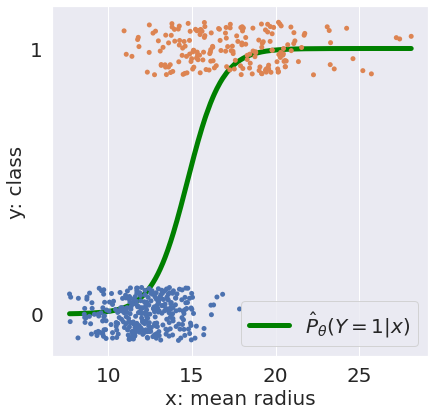

In [102]:
plt.figure(figsize=(6,6))
sns.stripplot(x=X.squeeze(), y=Y, 
              jitter = 0.1, orient='h');
sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.xlabel('x: mean radius')
plt.ylabel('y: class')
savefig("predict_prob")

<br/>

**Predict class labels**: By comparison, what does `.predict()` do?

It predicts 1 if the computed probability for class 1 is greater than 0.5, and 0 otherwise.

$$\text{classify}(x) = \begin{cases} 1, & P(Y = 1 | x) \geq 0.5 \\ 0, & \text{otherwise} \end{cases}$$

This is what we call **classification**.

Edit the above cells to see sklearn's prediction for a mean radius of `10`.

In [103]:
model.predict([[20]])

array([1])

<br/><br/>

Let's build a DataFrame to store this information. We may need it later.

In [104]:
# in case you want to see all of the probabilities and predictions
def make_prediction_df(X, Y, model):
    # assume X has one feature and that model is already fit 
    Prob = model.predict_proba(X)
    Y_hat = model.predict(X)
    df = pd.DataFrame({"X": X.squeeze(),
                       "Y": Y,
                       "P(Y = 1 | x)": Prob[:,1],
                       "Y_hat": Y_hat})
    return df
    
predict_train_df = make_prediction_df(X, Y, model)
predict_train_df

,X,Y,P(Y = 1 | x),Y_hat
0,25.220,1,0.999965,1
1,13.480,1,0.226448,0
2,11.290,0,0.033174,0
3,12.860,0,0.137598,0
4,19.690,1,0.992236,1
...,...,...,...,...
507,8.888,0,0.003257,0
508,11.640,0,0.046105,0
509,14.290,0,0.392796,0
510,13.980,1,0.323216,0


---

<br/><br/><br/>

# Linear Separability and the Need for Regularization


Suppose we had the following toy data:

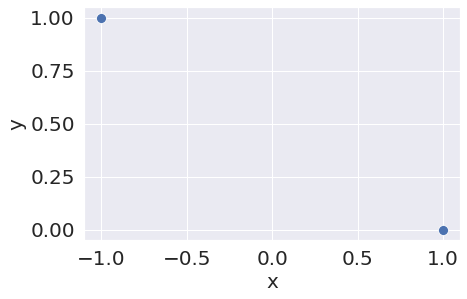

In [105]:
toy_df = pd.DataFrame({"x": [-1, 1], "y": [1, 0]})
#plt.scatter(toy_df['x'], toy_df['y'], s=100);
sns.scatterplot(data=toy_df, x='x', y='y',
              s=100, legend=None);
# plt.yticks([0, 1]);

Let's look at the mean cross-entropy loss surface for this toy dataset, and a single feature model $\hat{y} = \sigma(\theta x)$.



Let's consider a simplified logistic regression model of the form:

$$ \Large \hat{P}_{\theta}(Y = 1 | x) = \sigma(\theta_1 x) = \frac{1}{1 + e^{-\theta_1 x}} $$

With mean cross-entropy loss:

\begin{align}
\hat{\theta} &= \underset{\theta}{\operatorname{argmin}}  - \frac{1}{n} \sum_{i=1}^n \left( y_i \log (\sigma(\theta_1 x_i) + (1 - y_i) \log (1 - \sigma(\theta_1 x_i)) \right) \\
&= \underset{\theta}{\operatorname{argmin}} -\frac{1}{2} \left[ \log (\sigma( -  \theta_1 )) + \log(1 - \sigma(\theta_1))\right]
\end{align}

In [106]:
def toy_model(theta1, x):
    return 1/(1 + np.exp(-theta1 * x))

def mean_cross_entropy_loss_toy(theta1):
    # Here we use 1 - sigma(t) = sigma(-t) to improve numerical stability
    return - np.sum(toy_df['y'] * np.log(toy_model(theta1, toy_df['x'])) + \
                    (1-toy_df['y']) * np.log(toy_model(theta1, -toy_df['x'])))

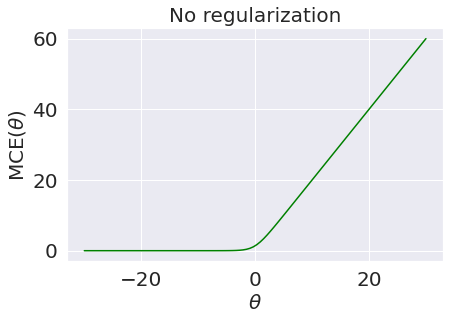

In [107]:
thetas = np.linspace(-30, 30, 100)
plt.plot(thetas, [mean_cross_entropy_loss_toy(theta) for theta in thetas], color = 'green')
plt.ylabel(r'MCE($\theta$)')
plt.xlabel(r'$\theta$');
plt.title("No regularization")
savefig("toy_loss")

But using **regularization**:

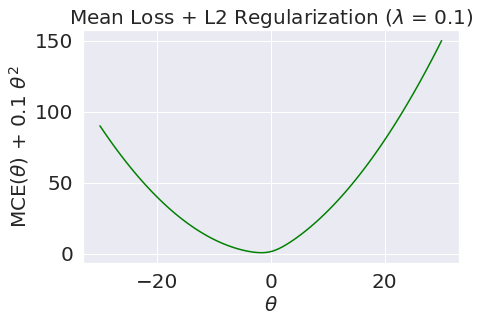

In [108]:
def mce_regularized_loss_single_arg_toy(theta, reg):
    return mce_loss_single_arg_toy(theta) + reg * theta**2 

def regularized_loss_toy(theta1, reg):
    return mean_cross_entropy_loss_toy(theta1) + reg * theta1**2

thetas = np.linspace(-30, 30, 100)
plt.plot(thetas, [regularized_loss_toy(theta, 0.1) for theta in thetas], color = 'green')
plt.ylabel(r'MCE($\theta$) + 0.1 $\theta^2$')
plt.xlabel(r'$\theta$');
plt.title(r"Mean Loss + L2 Regularization ($\lambda$ = 0.1)")
savefig("toy_loss_reg")

### Linearly separable plots

In case you were curious about how we generated the linearly separable plots for lecture.

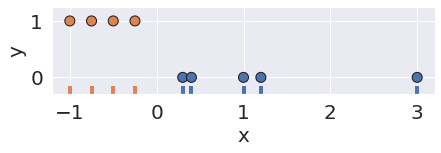

In [109]:
# change y_sep vs y_nosep
y_used = 'y_sep'

data_1d = pd.DataFrame(
    {"x": [-1, -.75, -.5, -.25, .3, .4, 1, 1.2, 3],
     "y_sep": [ 1,    1,   1,   1,   0,  0, 0, 0,   0],
     "y_nosep": [1,   0,   1,   0,   0,  0, 0, 0,   0]
    })

plt.figure(figsize=((6.1, 1.5)))
sns.scatterplot(data=data_1d, x='x', y=y_used,hue=y_used,
              s=100, edgecolor='k', linewidth=1, legend=None);
plt.ylim((-.3, 1.25))
plt.yticks([0, 1])
sns.rugplot(data=data_1d, x='x', hue=y_used, height = 0.1, legend=None, linewidth=4);
plt.ylabel("y")
savefig(f"1d_labels_{y_used}")

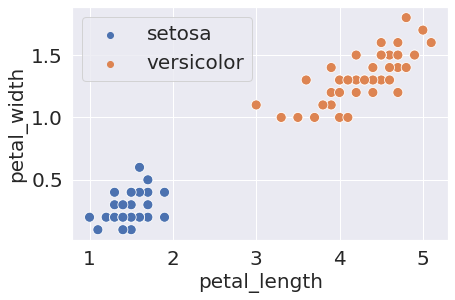

In [110]:
iris = sns.load_dataset('iris')

plt.figure(figsize=(6, 4))
# separable
sns.scatterplot(data = iris[iris['species'] != 'virginica'],
               x = 'petal_length',
               y = 'petal_width',
               hue = 'species', s=100);
plt.gca().legend_.set_title(None)
savefig("2d_sep")

And the following here is not:

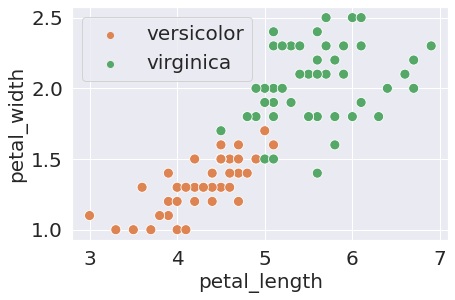

In [111]:
# not separable
plt.figure(figsize=(6, 4))
sns.scatterplot(data = iris[iris['species'] != 'setosa'],
               x = 'petal_length',
               y = 'petal_width',
               palette=sns.color_palette()[1:3],
               hue = 'species', s=100);
plt.gca().legend_.set_title(None)
savefig("2d_nosep")

In [112]:
len(sns.color_palette()[1:] + [sns.color_palette()[0]])

10

# Regularization Demo

As a demo of the model fitting process from end-to-end, let's fit a regularized LogisticRegression model on the `iris` data, while performing a train/test split.

Let's try and predict the species of our `iris`. But, there are three possible values of `species` right now:

In [113]:
iris = sns.load_dataset('iris')
iris['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

So let's create a new column `is_versicolor` that is 1 if the iris is a versicolor, and a 0 otherwise.

In [114]:
iris['is_versicolor'] = (iris['species'] == 'versicolor').astype(int)

In [115]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species,is_versicolor
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,0
146,6.3,2.5,5.0,1.9,virginica,0
147,6.5,3.0,5.2,2.0,virginica,0
148,6.2,3.4,5.4,2.3,virginica,0


In [116]:
cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [117]:
from sklearn.model_selection import train_test_split

In [118]:
iris_train, iris_test = train_test_split(iris, test_size = 0.2)

First, let's look at the coefficients if we fit without regularization:

In [119]:
iris_model_no_reg = LogisticRegression(penalty = 'none', solver = 'lbfgs')
iris_model_no_reg.fit(iris_train[cols], iris_train['is_versicolor'])

LogisticRegression(penalty='none')

In [120]:
iris_model_no_reg.coef_

array([[ 0.12498045, -2.89136261,  0.85130145, -1.9207463 ]])

In [121]:
iris_model_no_reg.intercept_

array([6.34097604])

Now let's fit with regularization, using the default value of `C` (the regularization hyperparameter in `scikit-learn`):

In [122]:
iris_model_reg = LogisticRegression(penalty = 'l2', solver = 'lbfgs')
iris_model_reg.fit(iris_train[cols], iris_train['is_versicolor'])

LogisticRegression()

In [123]:
iris_model_reg.coef_

array([[-0.05030759, -1.98719792,  0.53290676, -0.85618034]])

In [124]:
iris_model_reg.intercept_

array([4.6281646])

We can see the coefficients on the regularized model are significantly smaller.

Let's evaluate the training and testing accuracy of both models – regularized and not.

In [125]:
iris_model_no_reg.score(iris_train[cols], iris_train['is_versicolor'])

0.7083333333333334

In [126]:
iris_model_reg.score(iris_train[cols], iris_train['is_versicolor'])

0.6666666666666666

Unsurprisingly, the regularized model performs worse on the training data.

In [127]:
iris_model_no_reg.score(iris_test[cols], iris_test['is_versicolor'])

0.8

In [128]:
iris_model_reg.score(iris_test[cols], iris_test['is_versicolor'])

0.8333333333333334

In this case, they both happened to perform the same on the test data. Interesting!

**Question:** What did we forget to do here (that we should always do when performing regularized linear or logistic regression)?

---

<br/><br/><br/>

# Performance Metric

Back to the breast cancer dataset.

Here is our data:

In [129]:
# split the data
from sklearn.model_selection import train_test_split

# X, Y are training data
X = data_tr[['mean radius']].to_numpy()
Y = data_tr['malignant'].to_numpy()
X.shape, Y.shape

((512, 1), (512,))

In [130]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=True)
model.fit(X, Y); # X, Y are training data

Recall that sklearn's `model.predict()` will predict 1 if $P(Y = 1 | x) \geq 0.5$, and 0 otherwise.

<br/>

First, let's compute the **accuracy** of our `model` on our training dataset.



In [131]:
def accuracy(X, Y):
    return np.mean(model.predict(X) == Y)

accuracy(X, Y)

0.869140625

As per usual, `scikit-learn` can do this for us. The `.score` method of a `LogisticRegression` classifier gives us the accuracy of it.

In [132]:
model.score(X, Y)

0.869140625

### Confusion matrix

Our good old friend `scikit-learn` has an in-built confusion matrix method (of course it does).

In [133]:
from sklearn.metrics import confusion_matrix

# Be careful – confusion_matrix takes in y_true as the first parameter and y_pred as the second.
# Don't mix these up!
cm = confusion_matrix(Y, model.predict(X))
cm

array([[294,  23],
       [ 44, 151]])

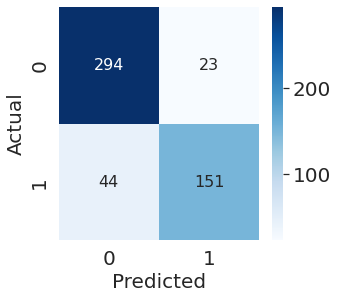

In [134]:
cm = confusion_matrix(Y, model.predict(X))
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');
savefig("cm")

### Precision and Recall

We can also compute the number of TP, TN, FP, and TN for our classifier, and hence its precision and recall.

In [135]:
Y_hat = model.predict(X)
tp = np.sum((Y_hat == 1) & (Y == 1))
tn = np.sum((Y_hat == 0) & (Y == 0))

fp = np.sum((Y_hat == 1) & (Y == 0))
fn = np.sum((Y_hat == 0) & (Y == 1))
tp, tn, fp, fn

(151, 294, 23, 44)

In [136]:
cm # [tn, fp]
   # [fn, tp]

array([[294,  23],
       [ 44, 151]])

These numbers match what we see in the confusion matrix above.

In [137]:
precision = tp / (tp + fp)
precision

0.867816091954023

In [138]:
recall = tp / (tp + fn)
recall

0.7743589743589744

It's important to remember that these values are all for the threshold of $T = 0.5$, which is `scikit-learn`'s default.

---

<br/><br/><br/>

# Adjusting the Classification Threshold

What does a prediction of 1 mean with the default sklearn threshold of $T = 0.5$?

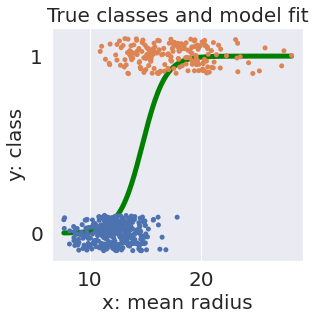

In [139]:
Prob_hat_one = model.predict_proba(X)[:, 1]

plt.figure(figsize=(4,4))
sns.stripplot(x=X.squeeze(), y=Y, 
              jitter = 0.1, orient='h');
sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.xlabel('x: mean radius')
plt.ylabel('y: class')
plt.title("True classes and model fit")
plt.legend().remove()
savefig("true")

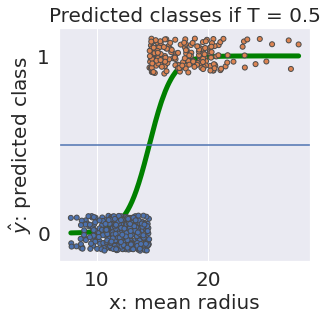

In [140]:
# predictions as well
Prob_hat_one = model.predict_proba(X)[:, 1]
Y_hat = model.predict(X) # threshold T = 0.5

plt.figure(figsize=(4,4))
sns.stripplot(x=X.squeeze(), y=Y_hat, 
              jitter = 0.1, orient='h', facecolors=None, linewidth=1);
sns.lineplot(x= X.squeeze(), y=Prob_hat_one,
             color='green', linewidth=5, label=r'$\hat{P}_{\theta}(Y = 1 | x)$')
plt.gca().invert_yaxis()
plt.axhline(y=0.5, label='T = 0.5')
plt.xlabel('x: mean radius')
plt.ylabel(r'$\hat{y}$: predicted class')
plt.legend().remove()
plt.title("Predicted classes if T = 0.5")
savefig("predict_05")

<br/><br/>

# Choosing a Threshold

What is the best threshold for a given performance metric?


## Accuracy

Accuracy threshold prediction on the train set:

In [141]:
bc_model = model        # fit to breast cancer dataset
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)

def accuracy_threshold(X, Y, T):
    return np.mean(predict_threshold(bc_model, X, T) == Y)

In [142]:
# compute accuracies for different thresholds on train set
thresholds = np.linspace(0, 1, 100)
accs = [accuracy_threshold(X, Y, t) for t in thresholds]


fig = px.line(x=thresholds, y=accs, title="Train Accuracy vs. Threshold")
fig.update_xaxes(title="threshold")
fig.update_yaxes(title="Accuracy")

In [143]:
# the threshold that maximizes accuracy
np.argmax(accs)

57

<br/>
<br/>

In practice we should use cross validation:

In [144]:
from sklearn import metrics

# used for sklearn's cross_val_score
def make_scorer(metric, T):
    return lambda model, X, Y: metric(Y, predict_threshold(model, X, T)) 

def acc_scorer(T):
    return make_scorer(metrics.accuracy_score, T)

In [145]:
from sklearn.model_selection import cross_val_score
cv_accs = [
    np.mean(cross_val_score(bc_model, X, Y, 
                            scoring=acc_scorer(t), 
                            cv=5))
    for t in thresholds
]

In [146]:
fig = px.line(x=thresholds, y=cv_accs, title="Cross-Validated Accuracy vs. Threshold")
fig.update_xaxes(title="threshold")
fig.update_yaxes(title="Accuracy")

In [148]:
# the threshold that maximizes cross-validation accuracy
thresholds[np.argmax(cv_accs)]

0.5656565656565657

<br/><br/><br/>

## ROC Curves

First let's plot both TPR vs. threshold and FPR vs. threshold.

In [149]:
bc_model = model        # fit to breast cancer dataset
def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)


def tpr_threshold(X, Y, T): # this is recall
    Y_hat = predict_threshold(bc_model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def fpr_threshold(X, Y, T):
    Y_hat = predict_threshold(bc_model, X, T)
    return np.sum((Y_hat == 1) & (Y == 0)) / np.sum(Y == 0)


In [150]:
# compute for different thresholds on train set
thresholds = np.linspace(0, 1, 100)
tprs = [tpr_threshold(X, Y, t) for t in thresholds]
fprs = [fpr_threshold(X, Y, t) for t in thresholds]

<br/><br/>

First we plot the TPR and FPR rates vs. threshold:

In [151]:
fig = go.Figure()
fig.add_trace(go.Scatter(name = 'TPR', x = thresholds, y = tprs))
fig.add_trace(go.Scatter(name = 'FPR', x = thresholds, y = fprs))
fig.update_xaxes(title="Threshold")
fig.update_yaxes(title="Proportion")

Some observations:
* T = 0 means everything is positive.
    * Then there are no TN (all of them are FP). → FPR = 1
    * We identified all true 1’s as 1, so TPR = recall = 1
* T = 1 means everything is negative.
    * Then there are no FP (all of them are TN). → FPR = 0
    * We identified zero true 1’s as 1, so TPR = recall = 0

In other words, TPR and FPR are both inversely proportional to the classification threshold T.

As we increase T, both TPR and FPR decrease.
* A decreased TPR is bad (detecting fewer positives).
* A decreased FPR is good (fewer false positives).

<br/>

Next, we plot the ROC curve.

In [152]:
fig = px.line(x=fprs, y = tprs, hover_name=thresholds, title="ROC Curve")
fig.update_xaxes(title="False Positive Rate")
fig.update_yaxes(title="True Positive Rate")
fig